# 고양이, 개 분류 - CNN v3
- Dropout 추가
- Kaggle에서 'Copy API Command'를 사용하여 API Key를 발급받을 것
- Full Data로 수행

- 데이터 다운로드 및 압축 해제, 훈련/테스트 데이터 분리

In [1]:
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
import json, os
with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']    # username from the json file
os.environ['KAGGLE_KEY'] = kaggle['key']       # key from the json file

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 98% 771M/788M [00:04<00:00, 218MB/s]
100% 788M/788M [00:04<00:00, 189MB/s]


In [4]:
!unzip microsoft-catsvsdogs-dataset.zip > /dev/null

In [5]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db')
cat_list = os.listdir(cat_dir)
len(cat_list)

12500

In [6]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db')
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

In [7]:
train_dir = 'PetImages/train'
test_dir = 'PetImages/test'
train_cats_dir = f'{train_dir}/cats'
train_dogs_dir = f'{train_dir}/dogs'
test_cats_dir = f'{test_dir}/cats'
test_dogs_dir = f'{test_dir}/dogs'

In [8]:
for dir_name in [train_dir,test_dir,train_cats_dir,train_dogs_dir,test_cats_dir,test_dogs_dir]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [9]:
for file in cat_list:
    if len(file) < 9:           # train data
        os.rename(f'{cat_dir}/{file}', f'{train_cats_dir}/{file}')
    else:                       # test data
        os.rename(f'{cat_dir}/{file}', f'{test_cats_dir}/{file}')

In [10]:
len(os.listdir(cat_dir)), len(os.listdir(train_cats_dir)), len(os.listdir(test_cats_dir))

(0, 10000, 2500)

In [11]:
for file in dog_list:
    if len(file) < 9:           # train data
        os.rename(f'{dog_dir}/{file}', f'{train_dogs_dir}/{file}')
    else:                       # test data
        os.rename(f'{dog_dir}/{file}', f'{test_dogs_dir}/{file}')

In [12]:
len(os.listdir(dog_dir)), len(os.listdir(train_dogs_dir)), len(os.listdir(test_dogs_dir))

(0, 10000, 2500)

In [13]:
os.rmdir(cat_dir)
os.rmdir(dog_dir)

- 데이터 탐색

In [14]:
import cv2
import matplotlib.pyplot as plt

In [15]:
# 파일 이름
test_cats_fnames = os.listdir(test_cats_dir)
test_dogs_fnames = os.listdir(test_dogs_dir)

print(test_cats_fnames[:5])
print(test_dogs_fnames[:5])

['10851.jpg', '11613.jpg', '10898.jpg', '11350.jpg', '12122.jpg']
['10851.jpg', '11613.jpg', '10898.jpg', '11350.jpg', '12122.jpg']


In [16]:
# 파일 갯수
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
len(train_cats_fnames), len(train_dogs_fnames)

(10000, 10000)

- 이미지 파일 에러 찾기

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
# 어느 파일에서 에러가 발생했는지 알아보는 코드
from PIL import Image
import glob
try:
    for fname in glob.glob(f'{test_cats_dir}/*.jpg'):
        img = Image.open(fname)
except:
    print(fname)

In [51]:
# cats/666.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체
# dogs/11702.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체
!cp PetImages/test/cats/12000.jpg PetImages/train/cats/666.jpg
!cp PetImages/test/dogs/12000.jpg PetImages/test/dogs/11702.jpg

- 모델 정의

In [17]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [54]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 36, 36, 32)       

- 모델 설정

In [55]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [57]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


- callback 정의

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [59]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch=1000,       # 한번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=250,       # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.56334, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.6459 - accuracy: 0.6521 - val_loss: 0.5633 - val_accuracy: 0.7124 - 70s/epoch - 70ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.56334 to 0.48998, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.5370 - accuracy: 0.7322 - val_loss: 0.4900 - val_accuracy: 0.7696 - 70s/epoch - 70ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.48998 to 0.48264, saving model to best-cat-dog-v3.h5
1000/1000 - 69s - loss: 0.4994 - accuracy: 0.7645 - val_loss: 0.4826 - val_accuracy: 0.7644 - 69s/epoch - 69ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.48264 to 0.41754, saving model to best-cat-dog-v3.h5
1000/1000 - 69s - loss: 0.4732 - accuracy: 0.7823 - val_loss: 0.4175 - val_accuracy: 0.8096 - 69s/epoch - 69ms/step
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.41754
1000/1000 - 69s - loss: 0.4513 - accuracy: 0.7971 - val_loss

In [60]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [61]:
from google.colab import files

up = files.upload()

Saving cat1.jfif to cat1.jfif
Saving cat2.jfif to cat2.jfif
Saving cat3.jfif to cat3.jfif
Saving cat4.jfif to cat4.jfif
Saving dog1.jfif to dog1.jfif
Saving dog2.jfif to dog2.jfif
Saving dog3.jfif to dog3.jfif
Saving dog4.jfif to dog4.jfif


In [62]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:       # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0000 cat1.jfif is a cat
0.0000 cat2.jfif is a cat
0.0000 cat3.jfif is a cat
0.0000 cat4.jfif is a cat
1.0000 dog1.jfif is a dog
1.0000 dog2.jfif is a dog
1.0000 dog3.jfif is a dog
1.0000 dog4.jfif is a dog


- 학습과정 시각화

In [63]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

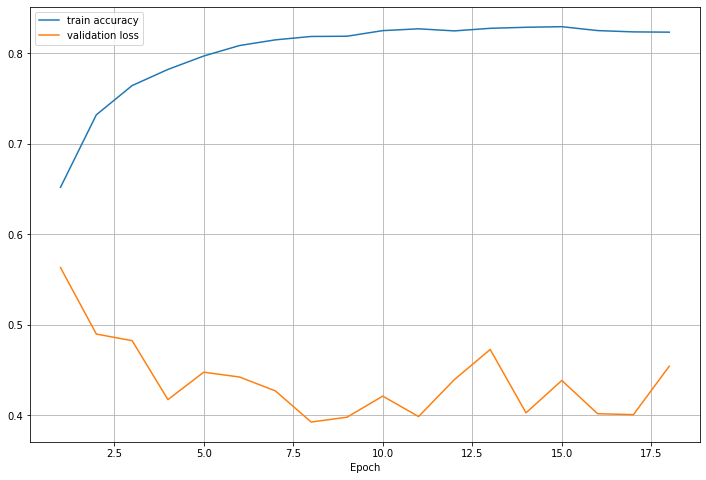

In [64]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()